10000
(18176,)


Text(0.5, 1.0, 'Speech.wav')

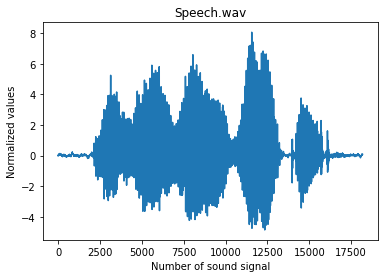

In [2]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
import math
import statsmodels.api as sm
import scipy
import soundpy as sp

fs, wav = wavfile.read('speech.wav')

# Normalization
wav = wav / np.sqrt(np.sum(wav ** 2))

print(fs)
print(wav.shape)
plt.plot(wav)
plt.xlabel('Number of sound signal')
plt.ylabel('Normalized values')
plt.title('Speech.wav')

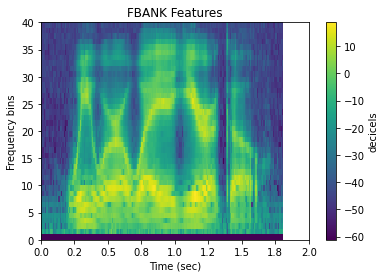

In [2]:
l1 = sp.plotsound(wav, sr = fs)

In [3]:
# Wiener Filtering
filter_order = 6 # 6, 15
window_size = 500 # 100, 200, 500

weight_store = []
error_store = []
for start in range(int(wav.shape[0]/window_size)):
    window_filter_x = np.array([wav[start*window_size+filter_order-i:window_size+start*window_size+filter_order-i] for i in range(1, filter_order+1)])
    window_filter_y = wav[start*window_size+filter_order:start*window_size+window_size+filter_order]

    R = np.zeros((filter_order, filter_order))
    for i in range (R.shape[0]):
        for j in range (R.shape[1]):
            R[i, j] = np.dot(window_filter_x[i], window_filter_x[j])
    #print(R)

    P = np.zeros((filter_order))
    for i in range (window_filter_x.shape[0]):
        P[i] = np.dot(window_filter_x[i], window_filter_y)
    #print(P)

    hopt = np.matmul(np.linalg.inv(R), P)
    weight_store.append(hopt)
    #print(hopt)

    y_hat = np.matmul(hopt, window_filter_x)
    y_error = np.sum(y_hat-window_filter_y)
    error_store.append(y_error)
    #l1 = sp.plotsound(y, sr = fs)
    #plt.show()

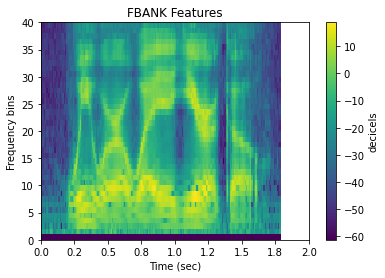

In [4]:
# Wiener Filtering
y_desire = []
for i in range (int(wav.shape[0]/window_size)):
    for j in range(window_size):
        y_desire.append(np.dot(weight_store[i], wav[i*window_size+j:i*window_size+j+filter_order][::-1]))
y_desire = np.array(y_desire)
l1 = sp.plotsound(y_desire, sr = fs)
plt.show()

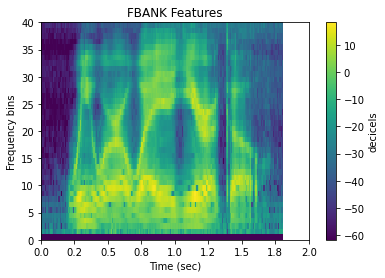

In [5]:
# LMS Algorithm

# weight_filter = np.zeros((filter_order))
weight_filter = np.random.normal(0, 0.1, filter_order)
mu = 0.005

weight_LMS_store = []
error_LMS_store = []

for start in range(wav.shape[0] - filter_order):
    window_filter_x = wav[start:start+filter_order]
    window_filter_y = wav[start+filter_order]
    
    e_n = window_filter_y - np.dot(weight_filter, window_filter_x)
    weight_filter = weight_filter + mu * window_filter_x * e_n
    
    weight_LMS_store.append(weight_filter)
    
    y_hat = np.matmul(weight_filter, window_filter_x)
    y_error = y_hat-window_filter_y
    error_LMS_store.append(y_error)

y_LMS_desire = []
for i in range (wav.shape[0]-filter_order):
    y_LMS_desire.append(np.dot(weight_LMS_store[i], wav[i:i+filter_order]))
y_LMS_desire = np.array(y_LMS_desire)
l1 = sp.plotsound(y_LMS_desire, sr = fs)
plt.show()

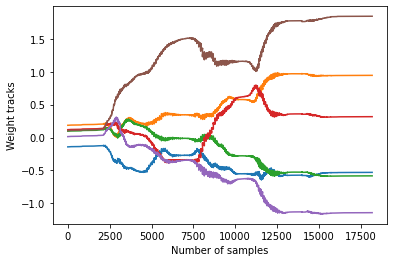

In [6]:
# weight
plt.plot(np.arange(len(weight_LMS_store)), weight_LMS_store)
plt.xlabel('Number of samples')
plt.ylabel('Weight tracks')
plt.show()

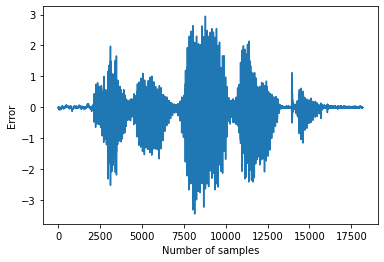

In [7]:
# error
plt.plot(np.arange(len(error_LMS_store)), error_LMS_store)
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.show()

In [20]:
aa = np.array([[1,2],[3,4]])
bb = np.array([4,3])
cc = np.dot(aa, bb)
bb.T@aa@bb

112

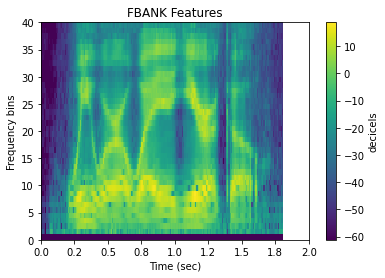

In [25]:
# RLS Algorithm

filter_order = 6 # 6, 15
delta = 0.001
forgetting_factor = 0.99 # 1, 0.99, 0.9, 0.7, 0.5
R_RLS = np.eye(filter_order) * delta
weight_filter = np.random.normal(0, 0.1, filter_order)

weight_RLS_store = []
error_RLS_store = []

for start in range(wav.shape[0]-filter_order):
    window_filter_x = wav[start:start+filter_order]
    window_filter_y = wav[start+filter_order]
    '''
    e_n = window_filter_y - np.dot(weight_filter, window_filter_x)
    z_n = np.dot(R_RLS, window_filter_x)
    q_n = np.dot(window_filter_x.T, z_n)
    z_n_normalized = z_n * 1/(forgetting_factor + q_n)
    weight_filter = weight_filter + z_n_normalized * e_n
    R_RLS = (R_RLS - np.matmul(z_n_normalized.reshape(1,-1).T, z_n.reshape(1,-1)))/forgetting_factor
    '''
    # reduce multiple computation and keep less intermediate variables to be displayed
    e_n = window_filter_y - np.dot(weight_filter, window_filter_x)
    z_n = np.dot(R_RLS, window_filter_x)
    q_n = np.dot(window_filter_x.T, z_n)
    weight_filter = weight_filter + (z_n * e_n)/(forgetting_factor + q_n)
    R_RLS = (R_RLS - np.matmul(z_n.reshape(1,-1).T, z_n.reshape(1,-1))/(forgetting_factor + q_n))/forgetting_factor
    
    '''
    e_n = window_filter_y - weight_filter@window_filter_x
    z_n = R_RLS@window_filter_x
    q_n = window_filter_x.T@R_RLS@window_filter_x
      
    weight_filter = weight_filter + (z_n*e_n)/(forgetting_factor+q_n)
    R_RLS = (R_RLS - z_n.reshape(-1,1)@z_n.reshape(1, -1)/(forgetting_factor+q_n) )/forgetting_factor
    '''
    
    weight_RLS_store.append(weight_filter)

    y_hat = np.matmul(weight_filter, window_filter_x)
    y_error = y_hat-window_filter_y
    error_RLS_store.append(y_error)
    

y_RLS_desire = []
for i in range (wav.shape[0]-filter_order):
    y_RLS_desire.append(np.dot(weight_RLS_store[i], wav[i:i+filter_order]))
y_RLS_desire = np.array(y_RLS_desire)
l2 = sp.plotsound(y_RLS_desire, sr = fs)
plt.show()

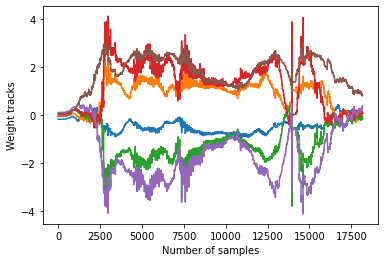

In [26]:
# weight
plt.plot(np.arange(len(weight_RLS_store)), weight_RLS_store)
plt.xlabel('Number of samples')
plt.ylabel('Weight tracks')
plt.show()

1703.2503645568997


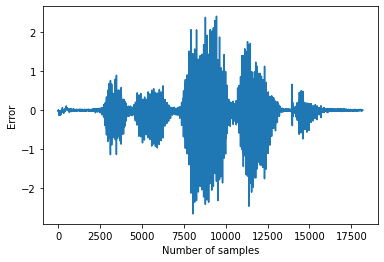

In [27]:
# error
plt.plot(np.arange(len(error_RLS_store)), error_RLS_store)
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.show()
print(np.sum(abs(np.array(error_RLS_store))))

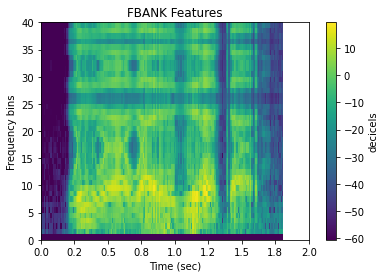

In [23]:
# APA Family (APA1)

filter_order = 6 # 6, 15
sample_size = 5
step_size = 0.005
weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA_store = []
error_APA_store = []

for start in range(int((wav.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([wav[start*sample_size+i:start*sample_size+i+filter_order] for i in range(sample_size)])
    window_filter_y = np.array([wav[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = weight_filter + step_size * window_filter_x.T @ (window_filter_y - window_filter_x @ weight_filter)
    
    weight_APA_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = y_hat-window_filter_y
    error_APA_store.append(y_error)
    

y_APA_desire = []
for i in range (int((wav.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        y_APA_desire.append(np.dot(weight_APA_store[i], wav[i*sample_size:i*sample_size+filter_order]))
y_APA_desire = np.array(y_APA_desire)
l2 = sp.plotsound(y_APA_desire, sr = fs)
plt.show()

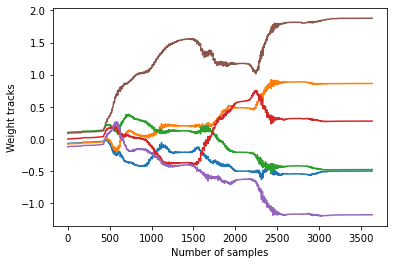

In [24]:
# weight
plt.plot(np.arange(len(weight_APA_store)), weight_APA_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

5625.112720870727


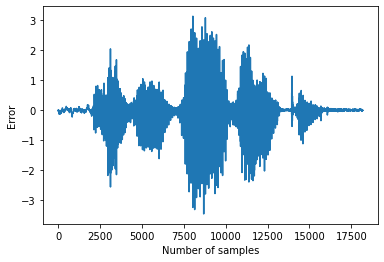

In [26]:
# error
error_APA_store = np.array(error_APA_store).flatten()
plt.plot(np.arange(len(error_APA_store)), error_APA_store)
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.show()
print(np.sum(abs(np.array(error_RLS_store))))

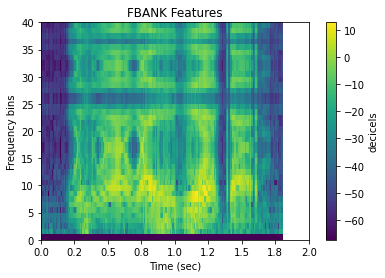

In [50]:
# APA Family (APA2)

filter_order = 6 # 6, 15
sample_size = 5
step_size = 0.0004
delta = 0.001
add_item = np.eye(sample_size) * delta
weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA_store = []
error_APA_store = []

for start in range(int((wav.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([wav[start*sample_size+i:start*sample_size+i+filter_order] for i in range(sample_size)])
    window_filter_y = np.array([wav[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = weight_filter + step_size * window_filter_x.T @ np.linalg.inv(window_filter_x @ window_filter_x.T + add_item) @ (window_filter_y - window_filter_x @ weight_filter)
    
    weight_APA_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = y_hat-window_filter_y
    error_APA_store.append(y_error)
    

y_APA_desire = []
for i in range (int((wav.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        y_APA_desire.append(np.dot(weight_APA_store[i], wav[i*sample_size:i*sample_size+filter_order]))
y_APA_desire = np.array(y_APA_desire)
l2 = sp.plotsound(y_APA_desire, sr = fs)
plt.show()

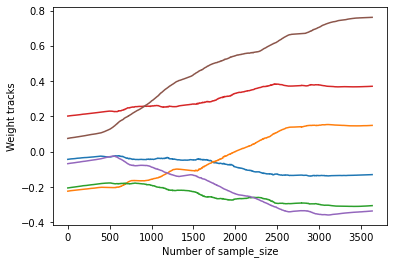

In [51]:
# weight
plt.plot(np.arange(len(weight_APA_store)), weight_APA_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

5625.112720870727


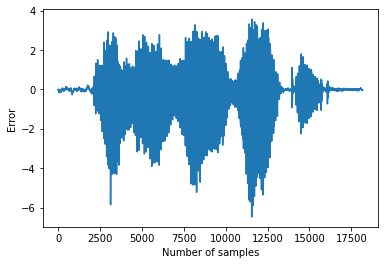

In [52]:
# error
error_APA_store = np.array(error_APA_store).flatten()
plt.plot(np.arange(len(error_APA_store)), error_APA_store)
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.show()
print(np.sum(abs(np.array(error_RLS_store))))

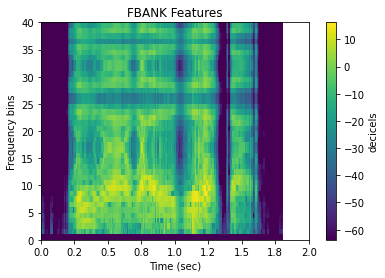

In [53]:
# APA Family (APA3)

filter_order = 6 # 6, 15
sample_size = 5
step_size = 0.005
lamda = 10
weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA_store = []
error_APA_store = []

for start in range(int((wav.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([wav[start*sample_size+i:start*sample_size+i+filter_order] for i in range(sample_size)])
    window_filter_y = np.array([wav[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = (1-step_size * lamda) * weight_filter + step_size * window_filter_x.T @ (window_filter_y - window_filter_x @ weight_filter)
    
    weight_APA_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = y_hat-window_filter_y
    error_APA_store.append(y_error)
    

y_APA_desire = []
for i in range (int((wav.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        y_APA_desire.append(np.dot(weight_APA_store[i], wav[i*sample_size:i*sample_size+filter_order]))
y_APA_desire = np.array(y_APA_desire)
l2 = sp.plotsound(y_APA_desire, sr = fs)
plt.show()

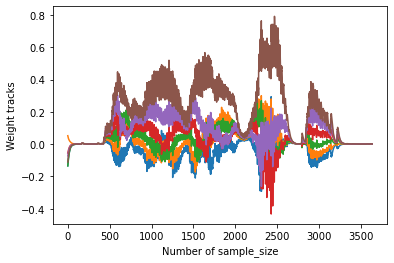

In [54]:
# weight
plt.plot(np.arange(len(weight_APA_store)), weight_APA_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

5625.112720870727


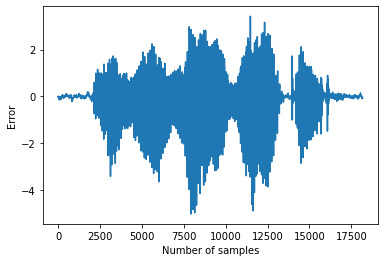

In [55]:
# error
error_APA_store = np.array(error_APA_store).flatten()
plt.plot(np.arange(len(error_APA_store)), error_APA_store)
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.show()
print(np.sum(abs(np.array(error_RLS_store))))

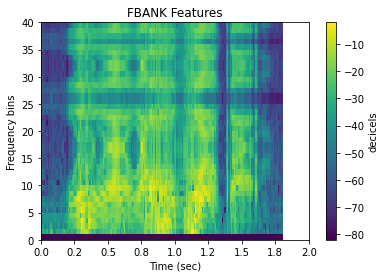

In [56]:
# APA Family (APA4)

filter_order = 6 # 6, 15
sample_size = 5
step_size = 0.00004
delta = 0.001
add_item = np.eye(sample_size) * delta
weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA_store = []
error_APA_store = []

for start in range(int((wav.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([wav[start*sample_size+i:start*sample_size+i+filter_order] for i in range(sample_size)])
    window_filter_y = np.array([wav[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = (1 - step_size) * weight_filter + step_size * window_filter_x.T @ np.linalg.inv(window_filter_x @ window_filter_x.T + add_item) @ window_filter_y
    
    weight_APA_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = y_hat-window_filter_y
    error_APA_store.append(y_error)
    

y_APA_desire = []
for i in range (int((wav.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        y_APA_desire.append(np.dot(weight_APA_store[i], wav[i*sample_size:i*sample_size+filter_order]))
y_APA_desire = np.array(y_APA_desire)
l2 = sp.plotsound(y_APA_desire, sr = fs)
plt.show()

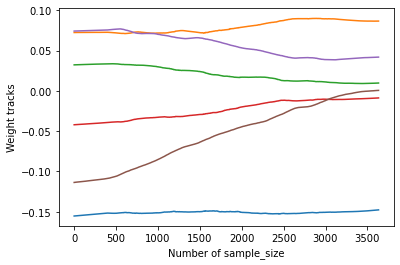

In [57]:
# weight
plt.plot(np.arange(len(weight_APA_store)), weight_APA_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

5625.112720870727


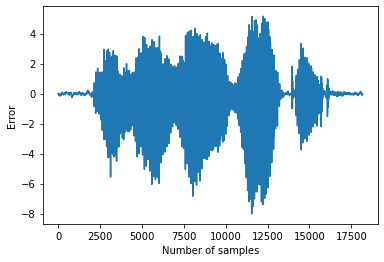

In [58]:
# error
error_APA_store = np.array(error_APA_store).flatten()
plt.plot(np.arange(len(error_APA_store)), error_APA_store)
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.show()
print(np.sum(abs(np.array(error_RLS_store))))